# Quantum Kernels — Hands-on

This notebook follows the *Quantum Kernels* lesson and mirrors its workflow with **runnable** code cells. It uses Qiskit (≥ 1.4) primitives and keeps Runtime calls optional.

**You will:**
1) Build a **single kernel entry** pipeline.
2) Extend to a **kernel matrix** and a **classical SVC**.
3) Inspect **circuit depth** and discuss **hardware-efficiency**.
4) Try a **scaled feature** example and observe depth.

> Math renders in VS Code (Jupyter) as LaTeX.


## Setup

```bash
# (Optional) environment
# conda create -n qkernels python=3.10 -y && conda activate qkernels
# pip install qiskit==1.4.2 qiskit-ibm-runtime scikit-learn matplotlib pandas
```
Imports:

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from qiskit.circuit.library import (
    ZFeatureMap, ZZFeatureMap, PauliFeatureMap, EfficientSU2, UnitaryOverlap,
)
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_distribution

np.set_printoptions(suppress=True, linewidth=120)

# Introduction to Quantum Kernels

The **quantum kernel method** refers to any approach that uses a quantum computer to estimate a kernel.  
Here, a *kernel* refers either to a kernel matrix or to individual elements of that matrix.

A **feature map** $\Phi(\mathbf{x})$ maps a classical data point $\mathbf{x} \in \mathbb{R}^d$  
to a higher-dimensional space $\Phi(\mathbf{x}) \in \mathbb{R}^{d'}$, typically with $d' > d$,  
to make data more linearly separable.  
The corresponding **kernel function** is defined as the inner product:

$$
K(\mathbf{x}, \mathbf{y}) = \langle \Phi(\mathbf{x}) | \Phi(\mathbf{y}) \rangle.
$$

In **quantum kernel methods**, this mapping $\Phi(\mathbf{x})$ is implemented by a quantum circuit,  
and $K(\mathbf{x}, \mathbf{y})$ is estimated by measurements on that circuit.

---

## Step 1 — Map Classical Inputs to a Quantum Problem

**Goal:** Encode classical data into the Hilbert space of quantum states.

Given two data vectors $\mathbf{x}_i$ and $\mathbf{x}_j$,  
their quantum feature-mapped states are:

$$
|\psi(\mathbf{x}_i)\rangle = \Phi(\mathbf{x}_i) |0\rangle^{\otimes N}, \quad
|\psi(\mathbf{x}_j)\rangle = \Phi(\mathbf{x}_j) |0\rangle^{\otimes N}.
$$

The kernel entry is then given by their overlap:

$$
\langle \psi(\mathbf{x}_j) | \psi(\mathbf{x}_i) \rangle 
= \langle 0|^{\otimes N} \, \Phi^{\dagger}(\mathbf{x}_j)\, \Phi(\mathbf{x}_i)\, |0\rangle^{\otimes N}.
$$

To estimate this overlap on hardware, we construct the combined circuit  
$\Phi^{\dagger}(\mathbf{x}_j)\Phi(\mathbf{x}_i)$ and measure the probability of all qubits  
being in the zero state:

$$
P(0^N) = 
\big|\langle 0|^{\otimes N}\, \Phi^{\dagger}(\mathbf{x}_j)\Phi(\mathbf{x}_i)\, |0\rangle^{\otimes N}\big|^2.
$$

This probability directly encodes the similarity between the two feature-mapped states,  
and is the quantity of interest when constructing a quantum kernel matrix.

---

## Step 2 — Optimize for Quantum Execution

**Goal:** Optimize the constructed circuit for a specific quantum backend.

We use Qiskit’s `generate_preset_pass_manager` with `optimization_level=3`  
to minimize circuit depth and gate errors before running on real hardware.  
This step focuses on improving physical circuit implementation,  
not on training or optimizing a machine learning model.

---

## Step 3 — Execute with Qiskit Runtime Primitives

**Goal:** Measure the output distribution.

We use the **Sampler** primitive to obtain a probability distribution (or quasi-probability distribution)  
of measurement outcomes.  
Noise and error mitigation may cause the total probability to slightly deviate from 1,  
hence the term *quasi-probability*.

The quantity of interest remains the zero-state probability $P(0^N)$.

---

## Step 4 — Post-Processing and Classical Use

**Goal:** Extract and use kernel values in classical ML.

From the measured distribution, compute the probability of the zero state $P(0^N)$  
for each pair of data points $(\mathbf{x}_i, \mathbf{x}_j)$  
and fill in the corresponding entry of the kernel matrix.

Once the full kernel matrix is obtained, it can be used in standard classical algorithms  
such as **Support Vector Machines (SVMs)**:

```python
from sklearn.svm import SVC
qml_svc = SVC(kernel="precomputed")


## Part A — Single Kernel Entry (two points)

### Step 1 — Map Classical Inputs to a Quantum Problem

To understand how a single element of the quantum kernel matrix is computed,  
we start with a small dataset containing only a few features (here, 10).  
Each classical data point $\mathbf{x}$ is encoded into a quantum state via a **feature map**,  
which produces a unitary transformation $U(\mathbf{x})$ acting on the all-zero state.

The overlap between two encoded states gives one kernel entry:

$$
K(\mathbf{x}_1, \mathbf{x}_2) = 
\langle \psi(\mathbf{x}_1) | \psi(\mathbf{x}_2) \rangle
= \langle 0|^{\otimes n} U^{\dagger}(\mathbf{x}_2) U(\mathbf{x}_1) |0\rangle^{\otimes n}.
$$

Measuring the probability of obtaining all zeros, $P(0^n)$, after applying  
$U^{\dagger}(\mathbf{x}_2)U(\mathbf{x}_1)$ gives $|K(\mathbf{x}_1, \mathbf{x}_2)|^2$.

Below, we prepare two mock data points and build the corresponding quantum feature maps  
using Qiskit’s **ZFeatureMap** circuit.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Two mock data points with category labels
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.10,  0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.020, -1],
]

# Remove labels to use only features
train_data = [small_data[0][:-1], small_data[1][:-1]]

print("Feature dimension:", len(train_data[0]))


Feature dimension: 10


### Building the Quantum Feature Map

We will now encode each data point using the **ZFeatureMap**,  
which applies Hadamard gates followed by parameterized Z rotations on each qubit.

For comparison, we note that Qiskit also provides a more entangled variant —  
the `ZZFeatureMap`, which introduces pairwise interactions between qubits.  
Here, we use the simpler `ZFeatureMap` to focus on the core concept.


C:\Users\think\AppData\Local\Temp\ipykernel_32888\1039837800.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])


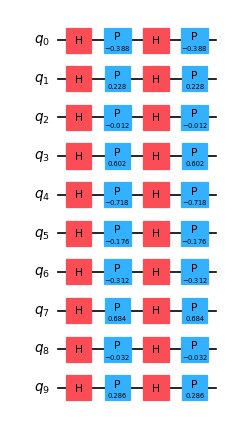

In [15]:
from qiskit.circuit.library import ZFeatureMap

# Define the ZFeatureMap for 10 features
fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])

# Assign data to build parameterized circuits
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

unitary1.decompose().draw("mpl", scale=0.6, style="iqp")


### Combining Two Feature Maps with `UnitaryOverlap`

The two unitaries $U_1$ and $U_2$ correspond to the encodings  
of the two different data points.  

To estimate their overlap, we construct the combined circuit  
$U^{\dagger}_2 U_1$ using **UnitaryOverlap** and measure all qubits.  
The probability of obtaining the all-zero bitstring then represents  
the similarity between the two quantum states.


C:\Users\think\AppData\Local\Temp\ipykernel_32888\1934563213.py:4: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  overlap_circ = UnitaryOverlap(unitary1, unitary2)


Circuit depth = 9


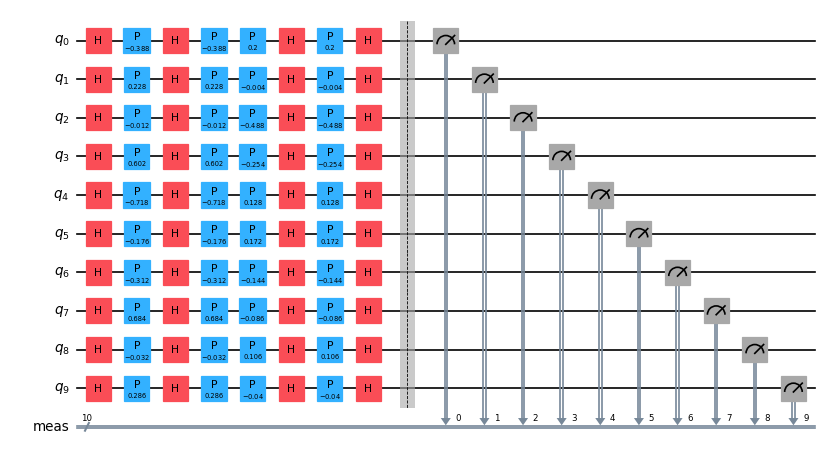

In [16]:
from qiskit.circuit.library import UnitaryOverlap

# Build the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

# Analyze circuit depth and structure
print("Circuit depth =", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")


### Interpretation

The printed **circuit depth** shows how complex the quantum encoding and overlap measurement are.  
For this simple 10-feature example, the decomposed circuit depth should be around **9**,  
indicating a shallow structure suitable for small quantum systems.

The resulting circuit visually represents the process of encoding two classical data points  
into quantum feature states and preparing them for kernel estimation.

---

## Step 2 — Optimize Problem for Quantum Execution

After defining our overlap circuit, we now prepare it for execution on a real quantum backend.  
This step ensures the circuit is **transpiled** (optimized) for the selected hardware’s native gate set and topology.

To do this, we first select the *least busy* IBM Quantum backend that can handle our circuit.  
Then, we apply **level 3 optimization**, which performs advanced qubit mapping, routing,  
and native gate decomposition to minimize circuit depth and noise.

In general:
- Optimization maps logical qubits to physical ones with the lowest error rates.  
- Real devices have limited connectivity, so some gates require SWAPs, increasing depth.  
- For simple circuits (like our overlap example), depth changes are minimal.


In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="1lfylLxHPLEPHKDt5clDW74LxNitlsfoLzgFrJfcYH7O", overwrite=True)


In [ ]:
hw = service.backends(simulator=False, operational=True)
print([(b.name, b.num_qubits) for b in hw])


qiskit_runtime_service.backends:WARNING:2025-11-03 17:03:59,292: Loading instance: Hackathon 2025-4-eu, plan: premium
qiskit_runtime_service.backends:WARNING:2025-11-03 17:03:59,292: Loading instance: Hackathon 2025-4, plan: premium


[]


In [28]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

qiskit_runtime_service._discover_backends_from_instance:WARNING:2025-11-03 17:02:52,130: Invalid instance crn:v1:bluemix:public:quantum-computing:eu-de:a/624a449c58db4cebbbcd6d44cd96889e:bbb8c7c3-fc99-4c87-9fb0-dd5af94860ee::
qiskit_runtime_service._discover_backends_from_instance:WARNING:2025-11-03 17:02:53,153: Invalid instance crn:v1:bluemix:public:quantum-computing:us-east:a/624a449c58db4cebbbcd6d44cd96889e:14cff560-d157-46d0-8582-98dad479797f::
qiskit_runtime_service.__init__:WARNING:2025-11-03 17:02:53,157: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (premium), the available account instances are: Hackathon 2025-4-eu, Hackathon 2025-4. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:

QiskitBackendNotFoundError: 'No backend matches the criteria.'

Once the backend is selected, we generate a **preset pass manager** at optimization level 3  
and apply it to our overlap circuit.  
This converts it into a fully executable circuit on the chosen IBM Quantum system.


In [29]:
# Apply level 3 optimization to our overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)


NameError: name 'backend' is not defined

Now, let’s check how the circuit depth changes after optimization.  
Decomposition may add two-qubit operations due to limited hardware connectivity,  
but for this small example, the difference is usually negligible.


In [52]:
print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)


circuit depth =  2


1

### Discussion

The **circuit depth** quantifies how many sequential layers of gates exist after decomposition.
- In this case, you should see a total depth of around **10**, with **1 two-qubit layer**.
- For larger feature maps or more qubits, the depth can increase significantly  
  because of additional routing and SWAP operations.

This step completes the *quantum compilation phase*, preparing our circuit for reliable execution on hardware.

---

## Step 3 — Execute Using Qiskit Runtime Primitives

Now that our optimized circuit is ready, we can execute it using the **Qiskit Runtime Primitives**.  
For small datasets with few features, simulation remains an option. However, for realistic or  
utility-scale calculations, quantum simulation quickly becomes infeasible because the required  
resources grow exponentially with the number of qubits.

Thus, simulators should be used primarily for debugging scaled-down code.

Below we include both the simulator-based and hardware-based execution paths.


In [1]:
# Run this for a simulator
# from qiskit.primitives import StatevectorSampler
 
# from qiskit_ibm_runtime import Options, Session, Sampler
 
# num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit
# sampler = StatevectorSampler()
# results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
# counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
# counts = results[0].data.meas.get_int_counts()


### Running on a Real Backend

Below, we execute the same circuit using the **IBM Runtime SamplerV2** primitive,  
which allows efficient and low-latency access to quantum hardware via the Qiskit Runtime service.  
We’ll use the previously selected backend and perform 10,000 shots for statistical accuracy.

Each run returns counts for the measured bitstrings, which represent measurement outcomes  
like `|001101...01⟩`. We can obtain both bitstring-labeled and integer-labeled versions of the counts.


In [2]:
# Benchmarked on an Eagle processor, 7-11-24, took 4 sec.
 
# Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
num_shots = 10000
 
# Use sampler and get the counts
sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()

# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()

# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()


NameError: name 'backend' is not defined

## Part B — Full Kernel Matrix + SVC

Tries to load `dataset_graph7.csv` (14 features + label). If not found, synthesizes a dataset of the same shape for a quick demo.

In [19]:
CSV_PATH = "dataset_graph7.csv"
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH, header=None)
    print("Loaded:", CSV_PATH, df.shape)
else:
    rng = np.random.default_rng(42)
    Xsyn = rng.normal(0, 1, size=(120, 14))
    ysyn = rng.choice([-1, 1], size=120)
    df = pd.DataFrame(np.hstack([Xsyn, ysyn.reshape(-1,1)]))
    print("Using synthetic dataset:", df.shape)

TRAIN_SIZE, TEST_SIZE = 90, 30
X_train = df.values[:TRAIN_SIZE, :-1]
y_train = df.values[:TRAIN_SIZE, -1]
X_test  = df.values[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE, :-1]
y_test  = df.values[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE, -1]
num_features = X_train.shape[1]
print("Features:", num_features, "| Train:", len(X_train), "| Test:", len(X_test))

Using synthetic dataset: (120, 15)
Features: 14 | Train: 90 | Test: 30


### Custom shallow feature map (sparse CZ + RX/RZ reuploading)

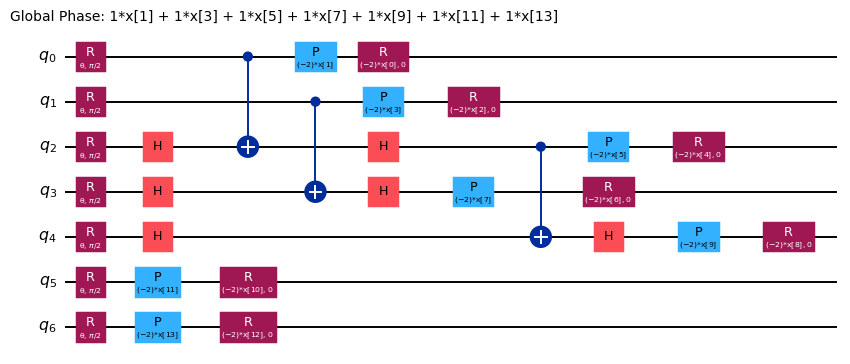

In [20]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

num_qubits = num_features // 2
entangler_map = [[0,1]] if num_qubits < 3 else [[0,2],[1,3],[2,4]]

theta = Parameter("θ")
phi   = ParameterVector("x", 2*num_qubits)

def build_custom_map(nq):
    qc = QuantumCircuit(nq)
    qc.ry(theta, qc.qubits)
    for a,b in entangler_map:
        if a < nq and b < nq:
            qc.cz(a,b)
    for i in range(nq):
        qc.rz(-2*phi[2*i+1], i)
        qc.rx(-2*phi[2*i], i)
    return qc

fm_custom = build_custom_map(num_qubits)
fm_custom.decompose().draw("mpl", scale=0.7)

### Kernel helpers

In [21]:
def kernel_entry(fm, xvec, yvec, shots=2048):
    nq = fm.num_qubits
    need = 2*nq
    xpad = np.zeros(need); xpad[:min(len(xvec), need)] = xvec[:min(len(xvec), need)]
    ypad = np.zeros(need); ypad[:min(len(yvec), need)] = yvec[:min(len(yvec), need)]
    Ux = fm.assign_parameters(list(xpad) + [np.pi/2])
    Uy = fm.assign_parameters(list(ypad) + [np.pi/2])
    circ = UnitaryOverlap(Ux, Uy)
    circ.measure_all()
    res = StatevectorSampler().run([circ], shots=shots).result()[0]
    counts = res.data.meas.get_int_counts()
    return counts.get(0, 0)/shots

def build_kernel_matrix(fm, X, shots=2048):
    n = len(X)
    K = np.eye(n)
    for i in range(n):
        for j in range(i+1, n):
            kij = kernel_entry(fm, X[i], X[j], shots=shots)
            K[i,j] = K[j,i] = kij
    return K

def build_test_matrix(fm, Xtest, Xtrain, shots=2048):
    t, n = len(Xtest), len(Xtrain)
    Kt = np.zeros((t, n))
    for i in range(t):
        for j in range(n):
            Kt[i,j] = kernel_entry(fm, Xtest[i], Xtrain[j], shots=shots)
    return Kt

### Compute matrices (demo sizes)

Use smaller slices first, then scale up.

In [22]:
N_TR, N_TE = 20, 10  # quick demo; raise to (90, 30) to mirror the lesson
Xtr, Ytr = X_train[:N_TR], y_train[:N_TR]
Xte, Yte = X_test[:N_TE],  y_test[:N_TE]

print("Building training kernel ...")
Ktr = build_kernel_matrix(fm_custom, Xtr, shots=2048)
print("Building test kernel ...")
Kte = build_test_matrix(fm_custom, Xte, Xtr, shots=2048)
print("Done.")

Building training kernel ...


C:\Users\think\AppData\Local\Temp\ipykernel_31332\1904023953.py:8: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  circ = UnitaryOverlap(Ux, Uy)


Building test kernel ...
Done.


### Train SVC on the precomputed kernel

In [23]:
from sklearn.svm import SVC
svc = SVC(kernel="precomputed")
svc.fit(Ktr, Ytr)
acc = svc.score(Kte, Yte)
print(f"Precomputed kernel classification test score: {acc:.3f}")

Precomputed kernel classification test score: 0.500


## Part C — Scaling: Many Features

Inspect depth with `ZZFeatureMap`, then switch to the custom map.

In [ ]:
x_big = np.linspace(-0.2, 0.8, 42)
y_big = np.linspace(-0.1, 0.6, 42)[::-1]
zz = ZZFeatureMap(feature_dimension=len(x_big), entanglement="linear", reps=1)
Ux = zz.assign_parameters(x_big)
Uy = zz.assign_parameters(y_big)
ov = UnitaryOverlap(Ux, Uy)
ov.measure_all()
print("ZZFeatureMap depth (pre-transpile):", ov.decompose().depth())

ZZFeatureMap depth (pre-transpile): 251


C:\Users\think\AppData\Local\Temp\ipykernel_31332\175457164.py:3: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  zz = ZZFeatureMap(feature_dimension=len(x_big), entanglement="linear", reps=1)
C:\Users\think\AppData\Local\Temp\ipykernel_31332\175457164.py:6: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  ov = UnitaryOverlap(Ux, Uy)


Switch to a custom sparse map with pairwise packing.

In [ ]:
nq_big = len(x_big)//2
fm_big = build_custom_map(nq_big)
Ux2 = fm_big.assign_parameters(list(x_big[:2*nq_big]) + [np.pi/2])
Uy2 = fm_big.assign_parameters(list(y_big[:2*nq_big]) + [np.pi/2])
ov2 = UnitaryOverlap(Ux2, Uy2)
ov2.measure_all()
print("Custom map depth (pre-transpile):", ov2.decompose().depth())
p0_big = kernel_entry(fm_big, x_big, y_big, shots=4096)
print(f"Scaled single-entry estimate P(0^n): {p0_big:.4f}")

IndexError: list index out of range

## Part D — Hardware-Efficient Notes

- Minimize two-qubit depth; prefer linear entanglement when possible.
- Consider device topology and native gates; transpilation may insert SWAPs.
- Depth/noise directly impact $P(0^n)$ stability for kernel estimation.

---
## Self-Check (short)
1. Why is `ZZFeatureMap` typically deeper than `ZFeatureMap`?
2. Why does measuring $P(0^n)$ yield $|\langle\psi(\mathbf{x})|\psi(\mathbf{y})\rangle|^2$?
3. When might classical kernels suffice (no clear quantum advantage)?

## (Optional) IBM Runtime SamplerV2 Sketch
```python
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=fm_custom.num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
ov_ibm = pm.run(overlap)
with Session(backend=backend) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([ov_ibm], shots=10000).result()[0]
    counts = result.data.meas.get_int_counts()
    print("P(0^n):", counts.get(0,0)/10000)
```


In [ ]:
## (Optional) IBM Runtime SamplerV2 Sketch
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=fm_custom.num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
ov_ibm = pm.run(overlap)
with Session(backend=backend) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([ov_ibm], shots=10000).result()[0]
    counts = result.data.meas.get_int_counts()
    print("P(0^n):", counts.get(0,0)/10000)

